In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import functools

In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.3.1+cpu
0.4.2+cpu


In [39]:
def get_num_correct(predictions, labels):
    return torch.argmax(predictions, dim=1).eq(labels).sum().item()

In [4]:
def func_aggregator(list_of_functions, operand):
    for function in list_of_functions:
        operand = function(operand)
    return operand

In [10]:
func_aggregator([lambda x:[i for i in x if i % 2 == 0], sum, print], [1,2,3,4])

6


In [38]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = torch.nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=60)
        self.fc3 = torch.nn.Linear(in_features=60, out_features=10)

        #Operations
        self.maxpool = functools.partial(F.max_pool2d, kernel_size=2, stride=2)
        self.relu = F.relu
        self.softmax = F.softmax

    def forward(self, t):
        t = self.conv1(t)
        t = self.relu(t)
        t = self.maxpool(t)

        t = self.conv2(t)
        t = self.relu(t)
        t = self.maxpool(t)

#         t = t.reshape(-1, 12*4*4)
        t = t.flatten(start_dim=1)
        t = self.fc1(t)
        t = self.relu(t)

        t = self.fc2(t)
        t = self.relu(t)

        t = self.fc3(t)
        return t

In [37]:
training_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train=True,
  download=True,
  transform = transforms.Compose([
    transforms.ToTensor()
  ])
)

In [11]:
data_loader?

Object `data_loader` not found.


In [44]:
images, labels = next(iter(data_loader))
grid = torchvision.utils.make_grid(images)# creates a grid of images

tb = SummaryWriter()
tb.add_image('images', grid) # add the grid to the tensorboard
tb.add_graph(network, images)

tb.close()

In [40]:
NUM_EPOCHS = 1
lr = 0.01
batch_size = 100
new_network = Network()
data_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(new_network.parameters(), lr=lr)

In [10]:
images, labels = next(iter(data_loader))
grid = torchvision.utils.make_grid(images)# creates a grid of images

comment = f' learning rate={lr}; batch size={batch_size}'
tb = SummaryWriter(comment=comment)
tb.add_image('images', grid) # add the grid to the tensorboard
tb.add_graph(network, images)

for i in range(NUM_EPOCHS):
    
    total_loss = 0
    total_correct = 0
    
    for batch in data_loader:
        images, labels = batch

        predictions = new_network(images)
        loss = F.cross_entropy(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_correct += get_num_correct(predictions, labels)
        total_loss += loss.item() * batch_size

    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Correct count', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(training_set), epoch)
    
#     tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
#     tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
#     tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)
    for name, weight in network.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)

    print("epoch: ", i,' loss: ', total_loss, ' correct: ', total_correct)

epoch:  0  loss:  353.1576067209244  correct:  46570
epoch:  1  loss:  240.32507067918777  correct:  51034
epoch:  2  loss:  216.84649454057217  correct:  51891
epoch:  3  loss:  206.24138398468494  correct:  52292
epoch:  4  loss:  202.21048863232136  correct:  52463
epoch:  5  loss:  196.3533470928669  correct:  52694
epoch:  6  loss:  196.58537830412388  correct:  52745
epoch:  7  loss:  192.64061133563519  correct:  52841
epoch:  8  loss:  194.7747795432806  correct:  52832
epoch:  9  loss:  190.70732675492764  correct:  52919


In [11]:
def get_all_predictions(model, loader):
    all_predictions = torch.tensor([])
    for batch in loader:
        images, labels = batch
        predictions = model(images)
        all_predictions = torch.cat((all_predictions, predictions), 
                                    dim=0)
    return all_predictions

In [12]:
# prediction_loader = torch.utils.data.DataLoader(training_set, 
#                                                 batch_size=100)
# train_predictions = get_all_predictions(new_network, 
#                                         prediction_loader)

In [13]:
# train_predictions

In [14]:
# train_predictions.requires_grad

In [15]:
# train_predictions.grad

In [16]:
# train_predictions.grad_fn

In [17]:
# it is best to turn grad off locally during testing of a network like below:

In [18]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(training_set, 
                                                batch_size=100)
    train_predictions = get_all_predictions(new_network, 
                                        prediction_loader)

In [19]:
#same effect a before but turns the grad off everytime the function is run

@torch.no_grad()
def get_n_correct_predictionsedictions(model, loader):
    all_predictions = torch.tensor([])
    for batch in loader:
        images, labels = batch
        predictions = model(images)
        all_predictions = torch.cat((all_predictions, predictions), 
                                    dim=0)
    return all_predictions

In [20]:
n_correct_predictions = get_num_correct(train_predictions, training_set.targets)
print('accuracy: ', n_correct_predictions/len(training_set))

accuracy:  0.8885833333333333


In [21]:
stacked = torch.stack([training_set.targets, train_predictions.argmax(dim=1)], dim=1)

In [22]:
stacked.shape

torch.Size([60000, 2])

In [23]:
confusion_matrix = torch.zeros(10, 10, dtype=torch.int16)

In [24]:
for pair in stacked:
    i,j = pair
    confusion_matrix[i,j] += 1

In [25]:
confusion_matrix

tensor([[5455,    1,  100,   92,   22,    2,  296,    1,   31,    0],
        [  24, 5845,    7,   77,   14,    0,   31,    0,    2,    0],
        [  65,    1, 4723,   64,  900,    1,  224,    0,   22,    0],
        [ 206,   26,   20, 5476,  186,    0,   83,    0,    3,    0],
        [  11,    1,  248,  231, 5212,    0,  284,    0,   12,    1],
        [   5,    0,    0,    0,    0, 5727,    1,  177,    0,   90],
        [1135,    0,  617,  130,  597,    1, 3474,    0,   46,    0],
        [   0,    0,    0,    0,    0,   27,    0, 5837,    2,  134],
        [  35,    0,   34,   21,   27,   30,   31,   22, 5790,   10],
        [   0,    0,    0,    1,    2,   19,    0,  200,    2, 5776]],
       dtype=torch.int16)

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [27]:
confusion_matrix_data = torch.tensor(
    confusion_matrix(
        training_set.targets, 
        train_predictions.argmax(dim=1)
    )
)

In [28]:
from plot_cm import plot_confusion_matrix

In [29]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)

In [30]:
[i for i in dir(confusion_matrix_data) if 'numpy' in i]

['numpy']

Confusion matrix, without normalization


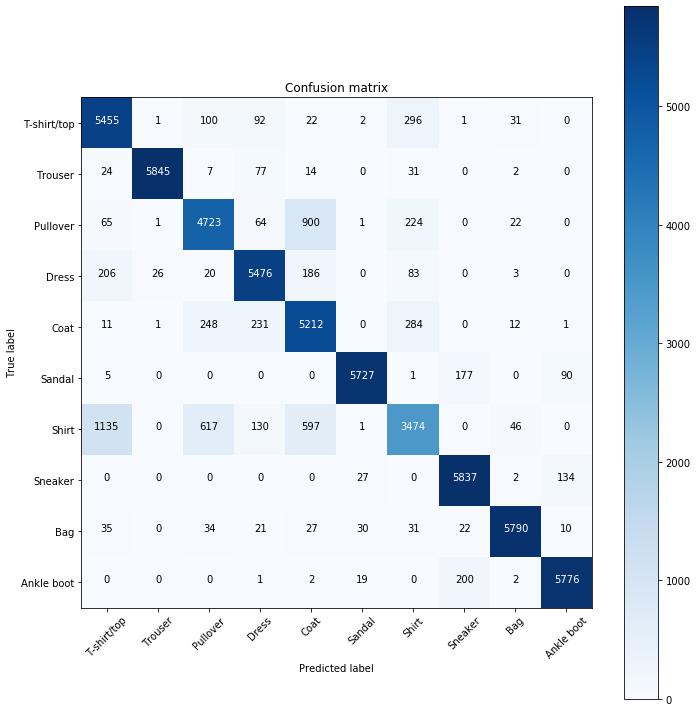

In [31]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix_data.numpy(), names, normalize=False)

In [32]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [33]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

In [34]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [ ]:
# To install and run tensorboard in shell
#----------------------------------------#
#!pip install tensorboard

#!tensorboard --version

#!tensorboard --logdir=runs

In [15]:
import inspect

x,y,z = 1,2,3

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var][0]

print(retrieve_name(y))

Y
